# Topic modeling and setiment analysis on Amazon reviews dataset

Goal: Applying Topic modeling and performing sentiment analysis on the reviews provided by users for each product
Dataset Size : 19525627 rows after performing the initial data cleaning 
Instead of performing on the complete dataset we are trying for first 50 rows for the initial performance analysis( part of this experiment is in progress). Our next experiment will be to run this on group of product IDs based on thier reviews

In [1]:
#Uploading necessary libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
# Gensim is library mostly suitable for topic modeling andnatural laguage processing
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

# Plotting tools for topics genrated
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
#Uploading data
df = pd.read_csv(r"C:\Users\sprad\Desktop\Amazon_Reviews_datasets\Clean_data.csv", index_col = 0)

C:\Users\sprad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df.shape

(19525627, 5)

In [7]:
#Retrieving unique ProductIds
unique_reviewIds = df.reviewerID.unique()
unique_ProductIds = df.asin.unique()
unique_reviewIds.size, unique_ProductIds.size

(9083456, 1237730)

In [8]:
#Slicing the first 50 unique productIds and retrieving their respected reviewtext
productIds= unique_ProductIds[:50]
productIds_list = productIds.tolist()
product_reviews = df[df['asin'].isin(productIds_list)]
product_reviews.head()

,overall,reviewerID,asin,reviewText,rev_date
0,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04
1,4.0,A2MNB77YGJ3CN0,B00004R940,I'll admit it -- I'm a bit of a snob when it c...,2000-05-07
2,5.0,A2Y8K7GP1QXUF4,B00004RFLJ,This is perfection. You will never use a bett...,2000-05-15
3,5.0,A3MDOV15JHNLB2,B00004SAF7,This corkscrew is amazing. There are several ...,2000-05-16
4,5.0,A1LUUO72VAFKFJ,B00004S4TZ,Maybe when Mom cooked for a big family every d...,2000-05-19


In [9]:
product_reviews.shape

(5843, 5)

In [11]:
#comparing the reviewIDs and their productID count. We can infer from the output that for 5800 productIds there are 5843 reviews
product_reviews_unique_reviewIds = product_reviews.reviewerID.unique()
product_reviews.shape,product_reviews_unique_reviewIds.size

((5843, 5), 5800)

In [12]:
#Slicing the reviews to sentences 
product_reviews_copy = product_reviews
review_sentences = pd.DataFrame(product_reviews_copy.reviewText.str.split('.').tolist(), index=product_reviews_copy.asin).stack()
review_sentences =review_sentences.reset_index([0, 'asin'])
review_sentences.columns = ['product_ID', 'sentences']

review_sentences

,product_ID,sentences
0,B00004SPEM,"For drip coffee at home, you can't go wrong wi..."
1,B00004SPEM,It's simple
2,B00004SPEM,"It filters the water, and it's easy to use"
3,B00004SPEM,It doesn't leak all over the counter or have...
4,B00004SPEM,"I've had both these problems with other, mo..."
...,...,...
26296,B00004UE75,Do not purchase //Reject
26297,B00004SGFA,I didn't realize this was a thing! So thankful...
26298,B00004SGFA,And its great for hiding/storing my attachmen...
26299,B00004SGFA,//Yes! Just yes


In [13]:
# Merging the two dataframes to get reviewer ID and over all rating
product_reviews_final = product_reviews_copy.merge(review_sentences, how='inner', left_on='asin', right_on='product_ID')
product_reviews_final

,overall,reviewerID,asin,reviewText,rev_date,product_ID,sentences
0,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,"For drip coffee at home, you can't go wrong wi..."
1,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,It's simple
2,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,"It filters the water, and it's easy to use"
3,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,It doesn't leak all over the counter or have...
4,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,"I've had both these problems with other, mo..."
...,...,...,...,...,...,...,...
16469252,5.0,A96D2IKR4GOJD,B00002ND67,nice //Five Stars,2018-05-11,B00002ND67,
16469253,5.0,A96D2IKR4GOJD,B00002ND67,nice //Five Stars,2018-05-11,B00002ND67,Works as advertised
16469254,5.0,A96D2IKR4GOJD,B00002ND67,nice //Five Stars,2018-05-11,B00002ND67,//Five Stars
16469255,5.0,A96D2IKR4GOJD,B00002ND67,nice //Five Stars,2018-05-11,B00002ND67,No fan in site //One Star


In [14]:
product_reviews_final.head()

,overall,reviewerID,asin,reviewText,rev_date,product_ID,sentences
0,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,"For drip coffee at home, you can't go wrong wi..."
1,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,It's simple
2,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,"It filters the water, and it's easy to use"
3,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,It doesn't leak all over the counter or have...
4,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04,B00004SPEM,"I've had both these problems with other, mo..."


In [15]:
df_final = product_reviews_final.drop(['reviewText', 'rev_date', 'product_ID'], axis = 1) #, 

In [16]:
df_final.head()

,overall,reviewerID,asin,sentences
0,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi..."
1,5.0,A84J7PUWOC138,B00004SPEM,It's simple
2,5.0,A84J7PUWOC138,B00004SPEM,"It filters the water, and it's easy to use"
3,5.0,A84J7PUWOC138,B00004SPEM,It doesn't leak all over the counter or have...
4,5.0,A84J7PUWOC138,B00004SPEM,"I've had both these problems with other, mo..."


In [17]:
df_final.shape

(16469257, 4)

In [18]:
#Downloading stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sprad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
#Importing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [20]:
reviews_data = df_final.sentences.values.tolist()
print(reviews_data[:1], len(reviews_data))

["For drip coffee at home, you can't go wrong with this unit"] 16469257


In [21]:
reviews_100k = reviews_data[:100000]
len(reviews_100k),reviews_100k[0]

(100000, "For drip coffee at home, you can't go wrong with this unit")

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# SPLIT SENTENCES INTO TOKENS

# reviews_data_100p__30000r_words = list(sent_to_words(reviews_data_100p_30000))
# print(reviews_data_100p__30000r_words[:1])


reviews_100k_words = list(sent_to_words(reviews_100k))
print(reviews_100k_words[:1])

[['for', 'drip', 'coffee', 'at', 'home', 'you', 'can', 'go', 'wrong', 'with', 'this', 'unit']]


In [23]:
# Build the bigram and trigram models FOR 30000

bigram = gensim.models.Phrases(reviews_100k_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[reviews_100k_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[reviews_100k_words[0]]])

['for', 'drip', 'coffee', 'at', 'home', 'you', 'can', 'go', 'wrong', 'with', 'this', 'unit']


In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
reviews_100k_words[:1]

[['for',
  'drip',
  'coffee',
  'at',
  'home',
  'you',
  'can',
  'go',
  'wrong',
  'with',
  'this',
  'unit']]

In [26]:
data_words_nostops = remove_stopwords(reviews_100k_words)
data_words_nostops[:1]

[['drip', 'coffee', 'home', 'go', 'wrong', 'unit']]

In [27]:
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_bigrams[:1]

[['drip', 'coffee', 'home', 'go', 'wrong', 'unit']]

In [28]:
# Remove Stop Words 
data_words_nostops = remove_stopwords(reviews_100k_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [29]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# WITHOUT LEMETIZATION
data_lemmatized = data_words_bigrams


print(data_lemmatized[:1])

[['drip', 'coffee', 'home', 'go', 'wrong', 'unit']]


In [30]:
print(data_lemmatized[:3])

[['drip', 'coffee', 'home', 'go', 'wrong', 'unit'], ['simple'], ['filters', 'water', 'easy']]


In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1)]]


In [32]:
id2word[8]

'filters'

In [33]:
print(id2word)

Dictionary(1866 unique tokens: ['coffee', 'drip', 'go', 'home', 'unit']...)


In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"set" + 0.078*"one" + 0.051*"like" + 0.036*"hand" + 0.034*"would" + '
  '0.031*"best" + 0.029*"used" + 0.028*"better" + 0.026*"ever" + '
  '0.024*"never"'),
 (1,
  '0.115*"knife" + 0.112*"peeler" + 0.055*"sharp" + 0.038*"paring" + '
  '0.028*"really" + 0.026*"work" + 0.025*"well" + 0.022*"much" + 0.022*"years" '
  '+ 0.019*"hold"'),
 (2,
  '0.179*"great" + 0.075*"hands" + 0.058*"products" + 0.039*"comfortable" + '
  '0.037*"kitchen" + 0.034*"get" + 0.026*"tools" + 0.024*"find" + '
  '0.024*"works" + 0.021*"already"'),
 (3,
  '0.100*"stars" + 0.072*"five" + 0.029*"grips" + 0.027*"buy" + 0.025*"blade" '
  '+ 0.025*"old" + 0.024*"cutting" + 0.023*"peel" + 0.016*"small" + '
  '0.015*"replaced"'),
 (4,
  '0.088*"good" + 0.070*"oxo" + 0.060*"love" + 0.041*"handles" + '
  '0.039*"quality" + 0.032*"bought" + 0.032*"arthritis" + 0.028*"excellent" + '
  '0.028*"grip" + 0.027*"easy"')]


In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.108294  0.194580       1        1  27.692642
0      0.209711 -0.320477       2        1  19.442226
4      0.135542  0.006971       3        1  19.079950
2     -0.401023 -0.147597       4        1  17.243460
3     -0.052523  0.266523       5        1  16.541712, topic_info=            Term          Freq         Total Category  logprob  loglift
173        great  16588.000000  16588.000000  Default  30.0000  30.0000
375        knife  17095.000000  17095.000000  Default  29.0000  29.0000
1543      peeler  16612.000000  16612.000000  Default  28.0000  28.0000
358        stars   8861.000000   8861.000000  Default  27.0000  27.0000
20          good   9006.000000   9006.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1575      barest    471.100098    472.014404   Topic5  -5.2386   1.7973
685   understand    473.779602    474.702789   Topic5  -5.2330   1.7973
1557       opted    472.424774    473.349670   Topic5  -5.2358   1.7973
1576     carrots   1103.879395   1114.508789   Topic5  -4.3871   1.7897
503          cut    610.567078   1044.497925   Topic5  -4.9793   1.2624

[195 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
442       1  0.999137       ago
150       4  0.999661   already
96        1  0.999465      also
1021      3  0.999246  although
741       2  0.999328   another
...     ...       ...       ...
557       1  0.999680      work
309       4  0.999661     works
111       2  0.999761     would
448       2  0.999434      year
533       1  0.999799     years

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

# Sentiment Analysis

In [37]:
import multiprocessing
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [38]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

In [39]:
w2v_model.build_vocab(reviews_100k_words, progress_per=10000)

In [40]:
w2v_100k_rev =  w2v_model.train(reviews_100k_words, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

In [41]:
print(w2v_100k_rev)

(3565061, 30604980)


In [42]:
w2v_model.init_sims(replace=True)

In [43]:
w2v_model.wv.most_similar(positive=["knife"])

[('paring', 0.797736406326294),
 ('peeler', 0.5501835346221924),
 ('pairing', 0.4731946885585785),
 ('handle', 0.47129473090171814),
 ('rusty', 0.43687060475349426),
 ('was', 0.423212468624115),
 ('victorinox', 0.41893237829208374),
 ('pair', 0.4179726839065552),
 ('combo', 0.41383129358291626),
 ('marketed', 0.4106493592262268)]

In [44]:
word_vectors = w2v_model.wv

In [45]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
positive_cluster_center = model.cluster_centers_[1]
negative_cluster_center = model.cluster_centers_[0]

In [46]:
model.cluster_centers_.shape

(2, 300)

In [48]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('portable', 0.8714675307273865),
 ('maker', 0.8644927740097046),
 ('krups', 0.8321988582611084),
 ('ra', 0.8199708461761475),
 ('purposes', 0.8127151131629944),
 ('worry', 0.8015117645263672),
 ('knief', 0.8009289503097534),
 ('cleaning', 0.7390648126602173),
 ('enthusiasts', 0.7374275922775269),
 ('tips', 0.7367936372756958)]

In [47]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('maker', 0.886778712272644),
 ('ra', 0.8444597721099854),
 ('portable', 0.8411903381347656),
 ('purposes', 0.811253547668457),
 ('worry', 0.7910318374633789),
 ('krups', 0.7852121591567993),
 ('breeze', 0.7477551698684692),
 ('tips', 0.7451471090316772),
 ('knief', 0.7441275119781494),
 ('enthusiasts', 0.7220495939254761)]

In [49]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors.wv[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [50]:
words.head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,for,"[-0.08013952, -0.011540869, 0.047063455, 0.012...",1,-1,1.019180,-1.019180
1,coffee,"[-0.0390505, 0.007112021, -0.12637912, -0.0375...",0,1,1.243237,1.243237
2,at,"[0.050017934, -0.022725035, -0.079533204, -0.0...",1,-1,1.038436,-1.038436
3,home,"[0.032633062, -0.02906009, 0.1007814, 0.008118...",1,-1,1.095950,-1.095950
4,you,"[-0.029972276, -0.017765151, -0.08759518, -0.0...",1,-1,1.023711,-1.023711


# TFDIF

In [63]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [64]:
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [66]:
product_reviews.head()

,overall,reviewerID,asin,reviewText,rev_date
0,5.0,A84J7PUWOC138,B00004SPEM,"For drip coffee at home, you can't go wrong wi...",2000-05-04
1,4.0,A2MNB77YGJ3CN0,B00004R940,I'll admit it -- I'm a bit of a snob when it c...,2000-05-07
2,5.0,A2Y8K7GP1QXUF4,B00004RFLJ,This is perfection. You will never use a bett...,2000-05-15
3,5.0,A3MDOV15JHNLB2,B00004SAF7,This corkscrew is amazing. There are several ...,2000-05-16
4,5.0,A1LUUO72VAFKFJ,B00004S4TZ,Maybe when Mom cooked for a big family every d...,2000-05-19


In [67]:
text = product_reviews.reviewText[0]

In [73]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

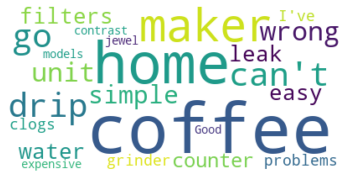

In [74]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [76]:
reviews_100k[:1]

["For drip coffee at home, you can't go wrong with this unit"]

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(reviews_100k)

In [78]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
# first_vector_tfidfvectorizer
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
drip,0.519033
coffee,0.469077
home,0.307552
unit,0.299480
wrong,0.289600
...,...
functional,0.000000
function,0.000000
fun,0.000000
full,0.000000
